In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
N = 1
X_train,Y_train = [],[]
a,b = np.random.randint(0, 2**N, size=(2,10000))
c = a+b
c = (a << N) | (c & (2**(2*N)-1))
X_train = (a << N) | b
Y_train = c

In [3]:
class QuantumOperator(keras.layers.Layer):
    
    def __init__(self, qubits, unitary_loss_factor=1., prob_loss_factor=1., **kwargs):
        self.dimension = 2**qubits
        self.unitary_loss_factor = unitary_loss_factor
        self.prob_loss_factor = prob_loss_factor
        super(QuantumOperator, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.operator_real = self.add_weight(
            shape=(self.dimension, self.dimension),
            initializer='glorot_normal', name='operator_real')
        self.operator_imag = self.add_weight(
            shape=(self.dimension, self.dimension),
            initializer='glorot_normal', name='operator_imag')
        super().build(input_shape)
    
    def call(self, inputs):
        operator = tf.complex(self.operator_real, self.operator_imag)
        forward = inputs @ operator
        reverse = forward @ tf.conj(tf.transpose(operator))
        prob = tf.square(tf.abs(forward))
        self.add_loss(self.unitary_loss_factor/2 * K.mean(keras.losses.mse(
            tf.real(inputs), tf.real(reverse))), inputs=inputs)
        self.add_loss(self.unitary_loss_factor/2 * K.mean(keras.losses.mse(
            tf.imag(inputs), tf.imag(reverse))), inputs=inputs)
        self.add_loss(self.prob_loss_factor * K.mean(keras.losses.mse(
            1., K.sum(prob, axis=-1))))
        return prob
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimension)

In [4]:
X = X_input = keras.layers.Input((1,), dtype='int32')
X = keras.layers.Lambda(lambda x: tf.complex(
    K.squeeze(K.one_hot(K.cast(x, 'int32'), 2**(2*N)), axis=-2), 0.))(X)
X_operator = QuantumOperator(2*N)
X = X_operator(X)
M = keras.Model(X_input, X)
M_opt = keras.optimizers.SGD(momentum=0.9, nesterov=True)
M.compile(M_opt, 'sparse_categorical_crossentropy')
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 4)                 0         
_________________________________________________________________
quantum_operator_1 (QuantumO (None, 4)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [5]:
M.fit(X_train, Y_train, epochs=10, callbacks=[
    keras.callbacks.ReduceLROnPlateau('loss', patience=10, verbose=1)
])

Epoch 1/10
10000/10000 [==============================] - 2s 168us/step - loss: 0.0476
Epoch 2/10
10000/10000 [==============================] - 1s 71us/step - loss: 3.5763e-07
Epoch 3/10
10000/10000 [==============================] - 1s 70us/step - loss: 3.5763e-07
Epoch 4/10
10000/10000 [==============================] - 1s 69us/step - loss: 3.5763e-07
Epoch 5/10
10000/10000 [==============================] - 1s 71us/step - loss: 3.5763e-07
Epoch 6/10
10000/10000 [==============================] - 1s 70us/step - loss: 3.5763e-07
Epoch 7/10
10000/10000 [==============================] - 1s 69us/step - loss: 3.5763e-07
Epoch 8/10
10000/10000 [==============================] - 1s 70us/step - loss: 3.5763e-07
Epoch 9/10
10000/10000 [==============================] - 1s 78us/step - loss: 3.5763e-07
Epoch 10/10
10000/10000 [==============================] - 1s 71us/step - loss: 3.5763e-07


In [6]:
operator = X_operator.get_weights()
operator = operator[0].T + operator[1].T*1j

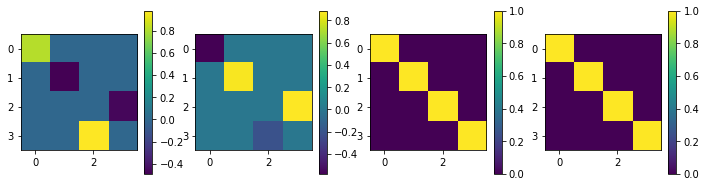

In [7]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(np.real(operator))
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(np.imag(operator))
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(np.real(operator @ np.conj(operator.T)))
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(np.real(np.conj(operator.T) @ operator))
plt.colorbar()
plt.show()

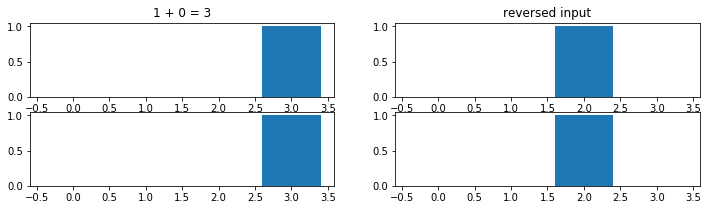

max prob by the regressed operator: 3 , sum of prob: 1.0


In [10]:
i = np.random.randint(0,len(X_train))
s = (operator @ keras.utils.to_categorical(X_train[i], num_classes=2**(2*N)))
x = np.square(np.abs(np.conj(operator.T) @ s))
y = np.square(np.abs(s))
plt.figure(figsize=(12,3))
plt.subplot(2,2,1)
plt.title(f'{a[i]} + {b[i]} = {c[i]}')
plt.bar(np.arange(2**(2*N)), y)
plt.subplot(2,2,3)
plt.bar(np.arange(2**(2*N)), keras.utils.to_categorical(Y_train[i], num_classes=2**(2*N)))
plt.subplot(2,2,2)
plt.title('reversed input')
plt.bar(np.arange(2**(2*N)), x)
plt.subplot(2,2,4)
plt.bar(np.arange(2**(2*N)), keras.utils.to_categorical(X_train[i], num_classes=2**(2*N)))
plt.show()
print('max prob by the regressed operator:', np.argmax(y), ', sum of prob:', np.sum(y))